In [1]:
import sys, os
import time

# This limits the amount of memory used:
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=2"

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy

In [2]:
#########################################################################
# Here's the Residual layer from the first half again:
#########################################################################
class ResidualLayer(tf.keras.Model):

    def __init__(self, n_filters):
        # tf.keras.Model.__init__(self)
        super(ResidualLayer, self).__init__()

        self.conv1 = tf.keras.layers.Conv2D(
            filters     = n_filters,
            kernel_size = (3,3),
            padding     = "same"
        )

        self.norm1 = tf.keras.layers.BatchNormalization()

        self.conv2 = tf.keras.layers.Conv2D(
            filters     = n_filters,
            kernel_size = (3,3),
            padding     = "same"
        )

        self.norm2 = tf.keras.layers.BatchNormalization()

    def call(self, inputs):

        x = inputs

        output1 = self.norm1(self.conv1(inputs))

        output1 = tf.keras.activations.relu(output1)

        output2 = self.norm2(self.conv2(output1))

        return tf.keras.activations.relu(output2 + x)

In [3]:
#########################################################################
# Here's layer that does a spatial downsampling:
#########################################################################
class ResidualDownsample(tf.keras.Model):

    def __init__(self, n_filters):
        # tf.keras.Model.__init__(self)
        super(ResidualDownsample, self).__init__()

        self.conv1 = tf.keras.layers.Conv2D(
            filters     = n_filters,
            kernel_size = (3,3),
            padding     = "same",
            strides     = (2,2)
        )

        self.identity = tf.keras.layers.Conv2D(
            filters     = n_filters,
            kernel_size = (1,1),
            strides     = (2,2),
            padding     = "same"
        )

        self.norm1 = tf.keras.layers.BatchNormalization()

        self.conv2 = tf.keras.layers.Conv2D(
            filters     = n_filters,
            kernel_size = (3,3),
            padding     = "same"
        )

        self.norm2 = tf.keras.layers.BatchNormalization()

    @tf.function
    def call(self, inputs):

        x = self.identity(inputs)
        output1 = self.norm1(self.conv1(inputs))
        output1 = tf.keras.activations.relu(output1)

        output2 = self.norm2(self.conv2(output1))

        return tf.keras.activations.relu(output2 + x)

In [4]:
#########################################################################
# Armed with that, let's build ResNet (this particular one is called ResNet34)
#########################################################################

class ResNet34(tf.keras.Model):

    def __init__(self):
        super(ResNet34, self).__init__()

        self.conv_init = tf.keras.Sequential([
            tf.keras.layers.Conv2D(
                filters     = 64,
                kernel_size = (7,7),
                strides     = (2,2),
                padding     = "same",
                use_bias    = False
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding="same")

        ])

        self.residual_series_1 = tf.keras.Sequential([
            ResidualLayer(64),
            ResidualLayer(64),
            ResidualLayer(64),
        ])

        # Increase the number of filters:
        self.downsample_1 = ResidualDownsample(128)

        self.residual_series_2 = tf.keras.Sequential([
            ResidualLayer(128),
            ResidualLayer(128),
            ResidualLayer(128),
        ])

        # Increase the number of filters:
        self.downsample_2 = ResidualDownsample(256)

        self.residual_series_3 = tf.keras.Sequential([
            ResidualLayer(256),
            ResidualLayer(256),
            ResidualLayer(256),
            ResidualLayer(256),
            ResidualLayer(256),
        ])

        # Increase the number of filters:
        self.downsample_3 = ResidualDownsample(512)


        self.residual_series_4 = tf.keras.Sequential([
            ResidualLayer(512),
            ResidualLayer(512),
        ])

        self.final_pool = tf.keras.layers.AveragePooling2D(
            pool_size=(8,8)
        )

        self.flatten = tf.keras.layers.Flatten()
        self.classifier = tf.keras.layers.Dense(1000)

    @tf.function
    def call(self, inputs):

        x = self.conv_init(inputs)

        x = self.residual_series_1(x)


        x = self.downsample_1(x)


        x = self.residual_series_2(x)

        x = self.downsample_2(x)

        x = self.residual_series_3(x)

        x = self.downsample_3(x)


        x = self.residual_series_4(x)


        x = self.final_pool(x)

        x = self.flatten(x)

        logits = self.classifier(x)

        return logits

In [5]:
@tf.function
def calculate_accuracy(logits, labels):
    # We calculate top1 accuracy only here:
    selected_class = tf.argmax(logits, axis=1)

    correct = tf.cast(selected_class, tf.float32) == tf.cast(labels, tf.float32)

    return tf.reduce_mean(tf.cast(correct, tf.float32))


@tf.function
def calculate_loss(logits, labels):
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, logits)
    return tf.reduce_mean(loss)

@tf.function
def training_step(network, optimizer, images, labels):
    with tf.GradientTape() as tape:
        logits = network(images)
        loss = calculate_loss(logits, labels)

    gradients = tape.gradient(loss, network.trainable_variables)

    optimizer.apply_gradients(zip(gradients, network.trainable_variables))

    accuracy = calculate_accuracy(logits, labels)

    return loss, accuracy

In [6]:
def train_epoch(i_epoch, step_in_epoch, train_ds, val_ds, network, optimizer, BATCH_SIZE, checkpoint):
    # Here is our training loop!

    steps_per_epoch = int(1281167 / BATCH_SIZE)
    steps_validation = int(50000 / BATCH_SIZE) 
    
    acc_summary = []
    loss_summary = []
    
    start = time.time()
    for train_images, train_labels in train_ds.take(steps_per_epoch):
        if step_in_epoch > steps_per_epoch: break
        else: step_in_epoch.assign_add(1)

        # Peform the training step for this batch
        loss, acc = training_step(network, optimizer, train_images, train_labels)

        loss_summary.append(loss)
        acc_summary.append(acc)
        #print(len(loss_summary))
        #print(numpy.array(loss_summary))
        #plt.plot(range(len(loss_summary)), numpy.array(loss_summary))
        
        end = time.time()
        images_per_second = BATCH_SIZE / (end - start)
        print(f"Finished step {step_in_epoch.numpy()} of {steps_per_epoch} in epoch {i_epoch.numpy()},loss={loss:.3f}, acc={acc:.3f} ({images_per_second:.3f} img/s).")
        start = time.time()
        
    plt.plot(range(len(loss_summary)), numpy.array(loss_summary))
    plt.plot(range(len(acc_summary)), numpy.array(acc_summary))

    # Save the network after every epoch:
    checkpoint.save("resnet34/model")

    # Compute the validation accuracy:
    mean_accuracy = None
    for val_images, val_labels in val_ds.take(steps_validation):
        logits = network(val_images)
        accuracy = calculate_accuracy(logits, val_labels)
        if mean_accuracy is None:
            mean_accuracy = accuracy
        else:
            mean_accuracy += accuracy

    mean_accuracy /= steps_validation

    print(f"Validation accuracy after epoch {i_epoch.numpy()}: {mean_accuracy:.4f}.")

In [7]:
def prepare_data_loader(BATCH_SIZE):


    tf.config.threading.set_inter_op_parallelism_threads(8)
    tf.config.threading.set_intra_op_parallelism_threads(8)

    print("Parameters set, preparing dataloading")
    #########################################################################
    # Here's the part where we load datasets:
    import json


    # What's in this function?  Tune in next week ...
    from ilsvrc_dataset import get_datasets


    class FakeHvd:

        def size(self): return 1

        def rank(self): return 0


    with open("ilsvrc.json", 'r') as f:
        config = json.load(f)

    print(json.dumps(config, indent=4))


    config['hvd'] = FakeHvd()
    config['data']['batch_size'] = BATCH_SIZE

    train_ds, val_ds = get_datasets(config)
    print("Datasets ready, creating network.")
    #########################################################################

    return train_ds, val_ds

Parameters set, preparing dataloading


--------------------------------------------------------------------------

  Local host:   thetagpu06
  Local device: mlx5_0
--------------------------------------------------------------------------


{
    "data": {
        "handler": "ilsvrc_dataset",
        "batch_size": 128,
        "train_filelist": "/lus/grand/projects/ALCFAITP/ilsvrc_train_filelist.txt",
        "test_filelist": "/lus/grand/projects/ALCFAITP/ilsvrc_val_filelist.txt",
        "shuffle_buffer": 200000,
        "reshuffle_each_iteration": true,
        "num_parallel_readers": 8,
        "prefectch_buffer_size": 10,
        "crop_image_size": [
            256,
            256
        ],
        "num_classes": 1000,
        "num_channels": 3
    }
}
num labels: 1000
build dataset /lus/grand/projects/ALCFAITP/ilsvrc_train_filelist.txt
input filelist contains 1281167 files, estimated batches per rank 5004
build dataset /lus/grand/projects/ALCFAITP/ilsvrc_val_filelist.txt
input filelist contains 50000 files, estimated batches per rank 195
Datasets ready, creating network.
Initial Image size:  (256, 256, 256, 3)
output shape: (256, 1000)
Model: "res_net34"
____________________________________________________________

Finished step 70 of 5004 in epoch 0,loss=5.253, acc=0.012 (623.409 img/s).
Finished step 71 of 5004 in epoch 0,loss=5.228, acc=0.027 (644.826 img/s).
Finished step 72 of 5004 in epoch 0,loss=5.213, acc=0.016 (719.078 img/s).
Finished step 73 of 5004 in epoch 0,loss=5.228, acc=0.012 (567.505 img/s).
Finished step 74 of 5004 in epoch 0,loss=5.283, acc=0.004 (635.237 img/s).
Finished step 75 of 5004 in epoch 0,loss=5.241, acc=0.020 (722.724 img/s).
Finished step 76 of 5004 in epoch 0,loss=5.354, acc=0.020 (633.682 img/s).
Finished step 77 of 5004 in epoch 0,loss=5.220, acc=0.035 (612.547 img/s).
Finished step 78 of 5004 in epoch 0,loss=5.365, acc=0.008 (609.735 img/s).
Finished step 79 of 5004 in epoch 0,loss=5.301, acc=0.023 (659.212 img/s).
Finished step 80 of 5004 in epoch 0,loss=5.224, acc=0.008 (544.411 img/s).
Finished step 81 of 5004 in epoch 0,loss=5.301, acc=0.020 (629.938 img/s).
Finished step 82 of 5004 in epoch 0,loss=5.306, acc=0.023 (742.429 img/s).
Finished step 83 of 5004 

Finished step 179 of 5004 in epoch 0,loss=5.199, acc=0.031 (737.519 img/s).
Finished step 180 of 5004 in epoch 0,loss=5.080, acc=0.023 (642.877 img/s).
Finished step 181 of 5004 in epoch 0,loss=5.089, acc=0.020 (705.978 img/s).
Finished step 182 of 5004 in epoch 0,loss=5.107, acc=0.020 (706.002 img/s).
Finished step 183 of 5004 in epoch 0,loss=5.111, acc=0.023 (648.978 img/s).
Finished step 184 of 5004 in epoch 0,loss=5.120, acc=0.027 (668.437 img/s).
Finished step 185 of 5004 in epoch 0,loss=5.003, acc=0.031 (719.835 img/s).
Finished step 186 of 5004 in epoch 0,loss=5.092, acc=0.047 (599.209 img/s).
Finished step 187 of 5004 in epoch 0,loss=5.283, acc=0.031 (629.018 img/s).
Finished step 188 of 5004 in epoch 0,loss=5.060, acc=0.035 (626.237 img/s).
Finished step 189 of 5004 in epoch 0,loss=4.954, acc=0.043 (674.577 img/s).
Finished step 190 of 5004 in epoch 0,loss=5.174, acc=0.043 (672.335 img/s).
Finished step 191 of 5004 in epoch 0,loss=5.141, acc=0.039 (701.215 img/s).
Finished ste

Finished step 287 of 5004 in epoch 0,loss=5.003, acc=0.043 (714.770 img/s).
Finished step 288 of 5004 in epoch 0,loss=5.147, acc=0.051 (595.983 img/s).
Finished step 289 of 5004 in epoch 0,loss=4.899, acc=0.035 (642.373 img/s).
Finished step 290 of 5004 in epoch 0,loss=4.998, acc=0.043 (686.111 img/s).
Finished step 291 of 5004 in epoch 0,loss=5.054, acc=0.051 (744.133 img/s).
Finished step 292 of 5004 in epoch 0,loss=4.923, acc=0.062 (659.347 img/s).
Finished step 293 of 5004 in epoch 0,loss=5.078, acc=0.043 (707.447 img/s).
Finished step 294 of 5004 in epoch 0,loss=5.071, acc=0.043 (763.443 img/s).
Finished step 295 of 5004 in epoch 0,loss=5.078, acc=0.027 (600.326 img/s).
Finished step 296 of 5004 in epoch 0,loss=4.933, acc=0.051 (622.471 img/s).
Finished step 297 of 5004 in epoch 0,loss=5.128, acc=0.027 (525.211 img/s).
Finished step 298 of 5004 in epoch 0,loss=5.037, acc=0.027 (774.089 img/s).
Finished step 299 of 5004 in epoch 0,loss=4.999, acc=0.043 (246.811 img/s).
Finished ste

Finished step 395 of 5004 in epoch 0,loss=5.216, acc=0.062 (627.081 img/s).
Finished step 396 of 5004 in epoch 0,loss=5.027, acc=0.051 (695.643 img/s).
Finished step 397 of 5004 in epoch 0,loss=5.088, acc=0.051 (732.948 img/s).
Finished step 398 of 5004 in epoch 0,loss=4.990, acc=0.055 (521.923 img/s).
Finished step 399 of 5004 in epoch 0,loss=5.061, acc=0.051 (661.612 img/s).
Finished step 400 of 5004 in epoch 0,loss=5.062, acc=0.062 (562.219 img/s).
Finished step 401 of 5004 in epoch 0,loss=4.985, acc=0.039 (727.096 img/s).
Finished step 402 of 5004 in epoch 0,loss=5.010, acc=0.066 (727.127 img/s).
Finished step 403 of 5004 in epoch 0,loss=5.061, acc=0.047 (732.554 img/s).
Finished step 404 of 5004 in epoch 0,loss=5.105, acc=0.051 (702.811 img/s).
Finished step 405 of 5004 in epoch 0,loss=4.932, acc=0.047 (693.475 img/s).
Finished step 406 of 5004 in epoch 0,loss=4.996, acc=0.047 (586.033 img/s).
Finished step 407 of 5004 in epoch 0,loss=4.922, acc=0.039 (667.017 img/s).
Finished ste

Finished step 503 of 5004 in epoch 0,loss=4.936, acc=0.070 (721.783 img/s).
Finished step 504 of 5004 in epoch 0,loss=5.087, acc=0.062 (602.147 img/s).
Finished step 505 of 5004 in epoch 0,loss=5.079, acc=0.047 (722.243 img/s).
Finished step 506 of 5004 in epoch 0,loss=5.078, acc=0.059 (681.001 img/s).
Finished step 507 of 5004 in epoch 0,loss=4.922, acc=0.062 (741.734 img/s).
Finished step 508 of 5004 in epoch 0,loss=5.090, acc=0.062 (668.128 img/s).
Finished step 509 of 5004 in epoch 0,loss=5.187, acc=0.074 (723.125 img/s).
Finished step 510 of 5004 in epoch 0,loss=5.068, acc=0.070 (696.655 img/s).
Finished step 511 of 5004 in epoch 0,loss=5.063, acc=0.047 (288.569 img/s).
Finished step 512 of 5004 in epoch 0,loss=4.806, acc=0.047 (747.086 img/s).
Finished step 513 of 5004 in epoch 0,loss=5.161, acc=0.039 (717.589 img/s).
Finished step 514 of 5004 in epoch 0,loss=5.237, acc=0.047 (698.746 img/s).
Finished step 515 of 5004 in epoch 0,loss=5.154, acc=0.059 (646.282 img/s).
Finished ste

Finished step 611 of 5004 in epoch 0,loss=4.979, acc=0.070 (697.244 img/s).
Finished step 612 of 5004 in epoch 0,loss=5.003, acc=0.066 (599.152 img/s).
Finished step 613 of 5004 in epoch 0,loss=4.934, acc=0.082 (677.913 img/s).
Finished step 614 of 5004 in epoch 0,loss=5.038, acc=0.082 (714.979 img/s).
Finished step 615 of 5004 in epoch 0,loss=4.944, acc=0.082 (654.285 img/s).
Finished step 616 of 5004 in epoch 0,loss=5.093, acc=0.059 (643.696 img/s).
Finished step 617 of 5004 in epoch 0,loss=5.136, acc=0.066 (729.625 img/s).
Finished step 618 of 5004 in epoch 0,loss=5.180, acc=0.086 (635.467 img/s).
Finished step 619 of 5004 in epoch 0,loss=5.168, acc=0.043 (707.173 img/s).
Finished step 620 of 5004 in epoch 0,loss=5.075, acc=0.055 (703.156 img/s).
Finished step 621 of 5004 in epoch 0,loss=5.152, acc=0.047 (656.559 img/s).
Finished step 622 of 5004 in epoch 0,loss=5.172, acc=0.039 (591.727 img/s).
Finished step 623 of 5004 in epoch 0,loss=5.089, acc=0.062 (693.053 img/s).
Finished ste

Finished step 719 of 5004 in epoch 0,loss=5.204, acc=0.047 (708.870 img/s).
Finished step 720 of 5004 in epoch 0,loss=5.089, acc=0.082 (692.868 img/s).
Finished step 721 of 5004 in epoch 0,loss=5.152, acc=0.062 (673.867 img/s).
Finished step 722 of 5004 in epoch 0,loss=4.899, acc=0.086 (279.171 img/s).
Finished step 723 of 5004 in epoch 0,loss=5.045, acc=0.090 (688.462 img/s).
Finished step 724 of 5004 in epoch 0,loss=5.002, acc=0.059 (575.156 img/s).
Finished step 725 of 5004 in epoch 0,loss=5.027, acc=0.047 (613.783 img/s).
Finished step 726 of 5004 in epoch 0,loss=5.118, acc=0.066 (680.416 img/s).
Finished step 727 of 5004 in epoch 0,loss=5.172, acc=0.066 (720.234 img/s).
Finished step 728 of 5004 in epoch 0,loss=5.110, acc=0.070 (637.760 img/s).
Finished step 729 of 5004 in epoch 0,loss=5.208, acc=0.031 (758.215 img/s).
Finished step 730 of 5004 in epoch 0,loss=4.888, acc=0.102 (623.235 img/s).
Finished step 731 of 5004 in epoch 0,loss=5.117, acc=0.047 (724.804 img/s).
Finished ste

Finished step 827 of 5004 in epoch 0,loss=5.024, acc=0.059 (660.733 img/s).
Finished step 828 of 5004 in epoch 0,loss=5.103, acc=0.066 (520.096 img/s).
Finished step 829 of 5004 in epoch 0,loss=5.081, acc=0.062 (672.107 img/s).
Finished step 830 of 5004 in epoch 0,loss=5.111, acc=0.059 (629.434 img/s).
Finished step 831 of 5004 in epoch 0,loss=5.106, acc=0.059 (712.322 img/s).
Finished step 832 of 5004 in epoch 0,loss=5.094, acc=0.051 (718.831 img/s).
Finished step 833 of 5004 in epoch 0,loss=5.160, acc=0.074 (595.454 img/s).
Finished step 834 of 5004 in epoch 0,loss=4.932, acc=0.062 (701.538 img/s).
Finished step 835 of 5004 in epoch 0,loss=5.188, acc=0.066 (754.580 img/s).
Finished step 836 of 5004 in epoch 0,loss=4.978, acc=0.090 (662.730 img/s).
Finished step 837 of 5004 in epoch 0,loss=5.019, acc=0.062 (699.229 img/s).
Finished step 838 of 5004 in epoch 0,loss=5.236, acc=0.043 (723.687 img/s).
Finished step 839 of 5004 in epoch 0,loss=5.259, acc=0.055 (611.874 img/s).
Finished ste

Finished step 935 of 5004 in epoch 0,loss=4.826, acc=0.109 (615.663 img/s).
Finished step 936 of 5004 in epoch 0,loss=5.365, acc=0.074 (503.431 img/s).
Finished step 937 of 5004 in epoch 0,loss=5.183, acc=0.055 (597.036 img/s).
Finished step 938 of 5004 in epoch 0,loss=5.092, acc=0.055 (730.281 img/s).
Finished step 939 of 5004 in epoch 0,loss=5.074, acc=0.059 (698.354 img/s).
Finished step 940 of 5004 in epoch 0,loss=4.853, acc=0.094 (719.617 img/s).
Finished step 941 of 5004 in epoch 0,loss=5.102, acc=0.070 (705.750 img/s).
Finished step 942 of 5004 in epoch 0,loss=5.038, acc=0.086 (637.481 img/s).
Finished step 943 of 5004 in epoch 0,loss=4.763, acc=0.090 (674.349 img/s).
Finished step 944 of 5004 in epoch 0,loss=4.954, acc=0.055 (644.458 img/s).
Finished step 945 of 5004 in epoch 0,loss=5.218, acc=0.098 (699.042 img/s).
Finished step 946 of 5004 in epoch 0,loss=4.952, acc=0.102 (685.783 img/s).
Finished step 947 of 5004 in epoch 0,loss=5.123, acc=0.059 (656.185 img/s).
Finished ste

Finished step 1043 of 5004 in epoch 0,loss=4.962, acc=0.086 (675.031 img/s).
Finished step 1044 of 5004 in epoch 0,loss=4.842, acc=0.086 (672.961 img/s).
Finished step 1045 of 5004 in epoch 0,loss=4.990, acc=0.094 (705.439 img/s).
Finished step 1046 of 5004 in epoch 0,loss=5.034, acc=0.102 (657.552 img/s).
Finished step 1047 of 5004 in epoch 0,loss=5.188, acc=0.035 (617.951 img/s).
Finished step 1048 of 5004 in epoch 0,loss=4.993, acc=0.094 (714.769 img/s).
Finished step 1049 of 5004 in epoch 0,loss=5.179, acc=0.066 (693.287 img/s).
Finished step 1050 of 5004 in epoch 0,loss=5.068, acc=0.066 (678.846 img/s).
Finished step 1051 of 5004 in epoch 0,loss=5.022, acc=0.078 (713.622 img/s).
Finished step 1052 of 5004 in epoch 0,loss=5.265, acc=0.078 (648.637 img/s).
Finished step 1053 of 5004 in epoch 0,loss=4.977, acc=0.070 (731.870 img/s).
Finished step 1054 of 5004 in epoch 0,loss=5.297, acc=0.055 (572.050 img/s).
Finished step 1055 of 5004 in epoch 0,loss=5.034, acc=0.109 (683.467 img/s).

Finished step 1150 of 5004 in epoch 0,loss=4.982, acc=0.094 (639.397 img/s).
Finished step 1151 of 5004 in epoch 0,loss=5.232, acc=0.055 (664.604 img/s).
Finished step 1152 of 5004 in epoch 0,loss=5.360, acc=0.066 (600.997 img/s).
Finished step 1153 of 5004 in epoch 0,loss=5.159, acc=0.078 (718.958 img/s).
Finished step 1154 of 5004 in epoch 0,loss=5.150, acc=0.066 (711.161 img/s).
Finished step 1155 of 5004 in epoch 0,loss=5.106, acc=0.062 (564.142 img/s).
Finished step 1156 of 5004 in epoch 0,loss=5.065, acc=0.066 (701.323 img/s).
Finished step 1157 of 5004 in epoch 0,loss=4.993, acc=0.059 (683.924 img/s).
Finished step 1158 of 5004 in epoch 0,loss=5.095, acc=0.066 (648.675 img/s).
Finished step 1159 of 5004 in epoch 0,loss=5.229, acc=0.070 (678.447 img/s).
Finished step 1160 of 5004 in epoch 0,loss=5.052, acc=0.059 (701.335 img/s).
Finished step 1161 of 5004 in epoch 0,loss=4.992, acc=0.062 (649.894 img/s).
Finished step 1162 of 5004 in epoch 0,loss=5.247, acc=0.055 (700.636 img/s).

Finished step 1257 of 5004 in epoch 0,loss=5.032, acc=0.078 (611.500 img/s).
Finished step 1258 of 5004 in epoch 0,loss=5.114, acc=0.043 (693.999 img/s).
Finished step 1259 of 5004 in epoch 0,loss=5.109, acc=0.059 (723.426 img/s).
Finished step 1260 of 5004 in epoch 0,loss=5.222, acc=0.051 (731.851 img/s).
Finished step 1261 of 5004 in epoch 0,loss=5.116, acc=0.051 (664.733 img/s).
Finished step 1262 of 5004 in epoch 0,loss=4.916, acc=0.094 (719.529 img/s).
Finished step 1263 of 5004 in epoch 0,loss=4.974, acc=0.102 (613.051 img/s).
Finished step 1264 of 5004 in epoch 0,loss=5.058, acc=0.086 (683.345 img/s).
Finished step 1265 of 5004 in epoch 0,loss=5.001, acc=0.086 (739.936 img/s).
Finished step 1266 of 5004 in epoch 0,loss=5.018, acc=0.082 (711.875 img/s).
Finished step 1267 of 5004 in epoch 0,loss=5.046, acc=0.078 (733.592 img/s).
Finished step 1268 of 5004 in epoch 0,loss=5.451, acc=0.055 (666.158 img/s).
Finished step 1269 of 5004 in epoch 0,loss=4.973, acc=0.090 (587.793 img/s).

Finished step 1364 of 5004 in epoch 0,loss=4.878, acc=0.105 (666.840 img/s).
Finished step 1365 of 5004 in epoch 0,loss=5.191, acc=0.059 (528.090 img/s).
Finished step 1366 of 5004 in epoch 0,loss=4.994, acc=0.105 (627.130 img/s).
Finished step 1367 of 5004 in epoch 0,loss=5.052, acc=0.078 (689.799 img/s).
Finished step 1368 of 5004 in epoch 0,loss=5.104, acc=0.066 (623.974 img/s).
Finished step 1369 of 5004 in epoch 0,loss=4.808, acc=0.098 (732.567 img/s).
Finished step 1370 of 5004 in epoch 0,loss=5.127, acc=0.066 (663.210 img/s).
Finished step 1371 of 5004 in epoch 0,loss=5.156, acc=0.082 (713.230 img/s).
Finished step 1372 of 5004 in epoch 0,loss=5.129, acc=0.078 (694.102 img/s).
Finished step 1373 of 5004 in epoch 0,loss=5.218, acc=0.098 (663.152 img/s).
Finished step 1374 of 5004 in epoch 0,loss=5.053, acc=0.047 (644.487 img/s).
Finished step 1375 of 5004 in epoch 0,loss=5.228, acc=0.082 (521.370 img/s).
Finished step 1376 of 5004 in epoch 0,loss=4.979, acc=0.117 (602.562 img/s).

Finished step 1471 of 5004 in epoch 0,loss=5.158, acc=0.082 (616.669 img/s).
Finished step 1472 of 5004 in epoch 0,loss=5.287, acc=0.094 (651.791 img/s).
Finished step 1473 of 5004 in epoch 0,loss=4.974, acc=0.121 (626.149 img/s).
Finished step 1474 of 5004 in epoch 0,loss=5.053, acc=0.121 (654.433 img/s).
Finished step 1475 of 5004 in epoch 0,loss=5.247, acc=0.066 (717.869 img/s).
Finished step 1476 of 5004 in epoch 0,loss=5.198, acc=0.102 (682.663 img/s).
Finished step 1477 of 5004 in epoch 0,loss=5.258, acc=0.066 (683.768 img/s).
Finished step 1478 of 5004 in epoch 0,loss=5.107, acc=0.098 (687.006 img/s).
Finished step 1479 of 5004 in epoch 0,loss=5.136, acc=0.062 (686.078 img/s).
Finished step 1480 of 5004 in epoch 0,loss=5.099, acc=0.129 (712.972 img/s).
Finished step 1481 of 5004 in epoch 0,loss=4.985, acc=0.090 (659.406 img/s).
Finished step 1482 of 5004 in epoch 0,loss=5.063, acc=0.078 (669.732 img/s).
Finished step 1483 of 5004 in epoch 0,loss=5.048, acc=0.090 (715.814 img/s).

Finished step 1578 of 5004 in epoch 0,loss=5.125, acc=0.090 (679.624 img/s).
Finished step 1579 of 5004 in epoch 0,loss=4.922, acc=0.117 (668.393 img/s).
Finished step 1580 of 5004 in epoch 0,loss=5.073, acc=0.098 (620.396 img/s).
Finished step 1581 of 5004 in epoch 0,loss=5.054, acc=0.062 (699.044 img/s).
Finished step 1582 of 5004 in epoch 0,loss=5.028, acc=0.094 (712.909 img/s).
Finished step 1583 of 5004 in epoch 0,loss=5.023, acc=0.062 (659.525 img/s).
Finished step 1584 of 5004 in epoch 0,loss=4.942, acc=0.121 (741.695 img/s).
Finished step 1585 of 5004 in epoch 0,loss=4.944, acc=0.082 (616.171 img/s).
Finished step 1586 of 5004 in epoch 0,loss=5.119, acc=0.086 (667.181 img/s).
Finished step 1587 of 5004 in epoch 0,loss=4.912, acc=0.098 (587.821 img/s).
Finished step 1588 of 5004 in epoch 0,loss=5.069, acc=0.070 (716.769 img/s).
Finished step 1589 of 5004 in epoch 0,loss=5.010, acc=0.086 (674.066 img/s).
Finished step 1590 of 5004 in epoch 0,loss=5.173, acc=0.078 (709.542 img/s).

Finished step 1685 of 5004 in epoch 0,loss=5.239, acc=0.070 (735.082 img/s).
Finished step 1686 of 5004 in epoch 0,loss=4.893, acc=0.129 (660.206 img/s).
Finished step 1687 of 5004 in epoch 0,loss=4.924, acc=0.098 (614.485 img/s).
Finished step 1688 of 5004 in epoch 0,loss=4.980, acc=0.109 (722.626 img/s).
Finished step 1689 of 5004 in epoch 0,loss=5.073, acc=0.074 (627.749 img/s).
Finished step 1690 of 5004 in epoch 0,loss=5.134, acc=0.113 (661.078 img/s).
Finished step 1691 of 5004 in epoch 0,loss=5.081, acc=0.102 (624.345 img/s).
Finished step 1692 of 5004 in epoch 0,loss=5.169, acc=0.121 (603.388 img/s).
Finished step 1693 of 5004 in epoch 0,loss=5.002, acc=0.125 (714.143 img/s).
Finished step 1694 of 5004 in epoch 0,loss=5.194, acc=0.062 (637.484 img/s).
Finished step 1695 of 5004 in epoch 0,loss=5.124, acc=0.102 (662.063 img/s).
Finished step 1696 of 5004 in epoch 0,loss=5.146, acc=0.121 (676.468 img/s).
Finished step 1697 of 5004 in epoch 0,loss=4.951, acc=0.090 (594.964 img/s).

Finished step 1792 of 5004 in epoch 0,loss=5.023, acc=0.105 (630.775 img/s).
Finished step 1793 of 5004 in epoch 0,loss=4.834, acc=0.113 (677.883 img/s).
Finished step 1794 of 5004 in epoch 0,loss=5.057, acc=0.109 (734.346 img/s).
Finished step 1795 of 5004 in epoch 0,loss=4.876, acc=0.109 (428.883 img/s).
Finished step 1796 of 5004 in epoch 0,loss=4.920, acc=0.137 (675.483 img/s).
Finished step 1797 of 5004 in epoch 0,loss=5.236, acc=0.078 (711.392 img/s).
Finished step 1798 of 5004 in epoch 0,loss=5.117, acc=0.098 (706.715 img/s).
Finished step 1799 of 5004 in epoch 0,loss=4.930, acc=0.086 (662.563 img/s).
Finished step 1800 of 5004 in epoch 0,loss=4.988, acc=0.094 (639.187 img/s).
Finished step 1801 of 5004 in epoch 0,loss=5.158, acc=0.102 (694.963 img/s).
Finished step 1802 of 5004 in epoch 0,loss=5.186, acc=0.086 (702.027 img/s).
Finished step 1803 of 5004 in epoch 0,loss=4.938, acc=0.129 (457.808 img/s).
Finished step 1804 of 5004 in epoch 0,loss=4.859, acc=0.105 (709.061 img/s).

Finished step 1899 of 5004 in epoch 0,loss=5.319, acc=0.078 (696.155 img/s).
Finished step 1900 of 5004 in epoch 0,loss=5.116, acc=0.098 (597.205 img/s).
Finished step 1901 of 5004 in epoch 0,loss=5.118, acc=0.098 (673.582 img/s).
Finished step 1902 of 5004 in epoch 0,loss=5.081, acc=0.082 (735.208 img/s).
Finished step 1903 of 5004 in epoch 0,loss=5.330, acc=0.113 (678.362 img/s).
Finished step 1904 of 5004 in epoch 0,loss=5.131, acc=0.129 (467.234 img/s).
Finished step 1905 of 5004 in epoch 0,loss=4.995, acc=0.102 (593.464 img/s).
Finished step 1906 of 5004 in epoch 0,loss=5.142, acc=0.102 (658.866 img/s).
Finished step 1907 of 5004 in epoch 0,loss=5.047, acc=0.109 (684.418 img/s).
Finished step 1908 of 5004 in epoch 0,loss=5.226, acc=0.109 (695.158 img/s).
Finished step 1909 of 5004 in epoch 0,loss=4.942, acc=0.113 (738.719 img/s).
Finished step 1910 of 5004 in epoch 0,loss=5.019, acc=0.098 (709.678 img/s).
Finished step 1911 of 5004 in epoch 0,loss=5.036, acc=0.113 (665.440 img/s).

Finished step 2006 of 5004 in epoch 0,loss=4.847, acc=0.148 (704.395 img/s).
Finished step 2007 of 5004 in epoch 0,loss=5.162, acc=0.086 (576.263 img/s).
Finished step 2008 of 5004 in epoch 0,loss=5.265, acc=0.086 (531.192 img/s).
Finished step 2009 of 5004 in epoch 0,loss=4.963, acc=0.117 (711.569 img/s).
Finished step 2010 of 5004 in epoch 0,loss=5.435, acc=0.082 (698.740 img/s).
Finished step 2011 of 5004 in epoch 0,loss=5.485, acc=0.074 (680.661 img/s).
Finished step 2012 of 5004 in epoch 0,loss=5.025, acc=0.082 (710.458 img/s).
Finished step 2013 of 5004 in epoch 0,loss=5.006, acc=0.082 (496.537 img/s).
Finished step 2014 of 5004 in epoch 0,loss=4.774, acc=0.098 (621.604 img/s).
Finished step 2015 of 5004 in epoch 0,loss=5.014, acc=0.090 (678.296 img/s).
Finished step 2016 of 5004 in epoch 0,loss=5.173, acc=0.082 (622.064 img/s).
Finished step 2017 of 5004 in epoch 0,loss=4.930, acc=0.160 (588.618 img/s).
Finished step 2018 of 5004 in epoch 0,loss=5.025, acc=0.133 (549.432 img/s).

Finished step 2113 of 5004 in epoch 0,loss=4.793, acc=0.141 (626.695 img/s).
Finished step 2114 of 5004 in epoch 0,loss=5.253, acc=0.121 (707.195 img/s).
Finished step 2115 of 5004 in epoch 0,loss=4.929, acc=0.102 (672.431 img/s).
Finished step 2116 of 5004 in epoch 0,loss=4.845, acc=0.117 (660.355 img/s).
Finished step 2117 of 5004 in epoch 0,loss=4.997, acc=0.117 (623.284 img/s).
Finished step 2118 of 5004 in epoch 0,loss=5.056, acc=0.129 (764.053 img/s).
Finished step 2119 of 5004 in epoch 0,loss=4.954, acc=0.105 (686.036 img/s).
Finished step 2120 of 5004 in epoch 0,loss=5.132, acc=0.078 (681.147 img/s).
Finished step 2121 of 5004 in epoch 0,loss=4.788, acc=0.086 (663.280 img/s).
Finished step 2122 of 5004 in epoch 0,loss=4.768, acc=0.145 (74.088 img/s).
Finished step 2123 of 5004 in epoch 0,loss=5.055, acc=0.102 (712.328 img/s).
Finished step 2124 of 5004 in epoch 0,loss=4.971, acc=0.090 (605.699 img/s).
Finished step 2125 of 5004 in epoch 0,loss=5.093, acc=0.074 (652.023 img/s).


Finished step 2220 of 5004 in epoch 0,loss=4.820, acc=0.129 (709.657 img/s).
Finished step 2221 of 5004 in epoch 0,loss=4.948, acc=0.129 (706.258 img/s).
Finished step 2222 of 5004 in epoch 0,loss=4.904, acc=0.109 (683.776 img/s).
Finished step 2223 of 5004 in epoch 0,loss=5.349, acc=0.105 (738.031 img/s).
Finished step 2224 of 5004 in epoch 0,loss=5.316, acc=0.082 (586.133 img/s).
Finished step 2225 of 5004 in epoch 0,loss=5.143, acc=0.086 (664.177 img/s).
Finished step 2226 of 5004 in epoch 0,loss=5.223, acc=0.102 (648.963 img/s).
Finished step 2227 of 5004 in epoch 0,loss=5.202, acc=0.133 (693.235 img/s).
Finished step 2228 of 5004 in epoch 0,loss=5.064, acc=0.117 (728.090 img/s).
Finished step 2229 of 5004 in epoch 0,loss=5.075, acc=0.137 (652.776 img/s).
Finished step 2230 of 5004 in epoch 0,loss=4.917, acc=0.152 (495.089 img/s).
Finished step 2231 of 5004 in epoch 0,loss=4.991, acc=0.117 (537.279 img/s).
Finished step 2232 of 5004 in epoch 0,loss=4.900, acc=0.117 (607.409 img/s).

Finished step 2327 of 5004 in epoch 0,loss=5.111, acc=0.121 (668.782 img/s).
Finished step 2328 of 5004 in epoch 0,loss=5.119, acc=0.113 (683.176 img/s).
Finished step 2329 of 5004 in epoch 0,loss=5.067, acc=0.109 (603.365 img/s).
Finished step 2330 of 5004 in epoch 0,loss=5.015, acc=0.090 (567.180 img/s).
Finished step 2331 of 5004 in epoch 0,loss=4.948, acc=0.133 (681.154 img/s).
Finished step 2332 of 5004 in epoch 0,loss=5.089, acc=0.109 (676.705 img/s).
Finished step 2333 of 5004 in epoch 0,loss=5.155, acc=0.125 (712.670 img/s).
Finished step 2334 of 5004 in epoch 0,loss=5.145, acc=0.082 (724.076 img/s).
Finished step 2335 of 5004 in epoch 0,loss=5.104, acc=0.105 (671.684 img/s).
Finished step 2336 of 5004 in epoch 0,loss=4.885, acc=0.121 (622.606 img/s).
Finished step 2337 of 5004 in epoch 0,loss=5.061, acc=0.156 (683.279 img/s).
Finished step 2338 of 5004 in epoch 0,loss=5.160, acc=0.105 (574.572 img/s).
Finished step 2339 of 5004 in epoch 0,loss=5.114, acc=0.125 (674.015 img/s).

Finished step 2434 of 5004 in epoch 0,loss=4.894, acc=0.148 (612.114 img/s).
Finished step 2435 of 5004 in epoch 0,loss=5.095, acc=0.098 (647.361 img/s).
Finished step 2436 of 5004 in epoch 0,loss=5.015, acc=0.117 (638.796 img/s).
Finished step 2437 of 5004 in epoch 0,loss=4.921, acc=0.117 (637.455 img/s).
Finished step 2438 of 5004 in epoch 0,loss=4.880, acc=0.090 (732.848 img/s).
Finished step 2439 of 5004 in epoch 0,loss=4.969, acc=0.090 (627.711 img/s).
Finished step 2440 of 5004 in epoch 0,loss=4.963, acc=0.094 (646.383 img/s).
Finished step 2441 of 5004 in epoch 0,loss=4.781, acc=0.109 (658.534 img/s).
Finished step 2442 of 5004 in epoch 0,loss=4.901, acc=0.145 (643.655 img/s).
Finished step 2443 of 5004 in epoch 0,loss=4.757, acc=0.164 (679.756 img/s).
Finished step 2444 of 5004 in epoch 0,loss=4.800, acc=0.129 (666.329 img/s).
Finished step 2445 of 5004 in epoch 0,loss=4.907, acc=0.129 (603.899 img/s).
Finished step 2446 of 5004 in epoch 0,loss=4.748, acc=0.117 (667.856 img/s).

Finished step 2541 of 5004 in epoch 0,loss=5.085, acc=0.109 (645.106 img/s).
Finished step 2542 of 5004 in epoch 0,loss=5.064, acc=0.098 (593.444 img/s).
Finished step 2543 of 5004 in epoch 0,loss=4.962, acc=0.113 (622.560 img/s).
Finished step 2544 of 5004 in epoch 0,loss=5.031, acc=0.109 (681.876 img/s).
Finished step 2545 of 5004 in epoch 0,loss=4.813, acc=0.090 (678.954 img/s).
Finished step 2546 of 5004 in epoch 0,loss=5.147, acc=0.086 (653.352 img/s).
Finished step 2547 of 5004 in epoch 0,loss=4.859, acc=0.125 (688.882 img/s).
Finished step 2548 of 5004 in epoch 0,loss=4.946, acc=0.125 (679.443 img/s).
Finished step 2549 of 5004 in epoch 0,loss=5.099, acc=0.109 (743.841 img/s).
Finished step 2550 of 5004 in epoch 0,loss=5.167, acc=0.121 (653.202 img/s).
Finished step 2551 of 5004 in epoch 0,loss=4.945, acc=0.105 (685.708 img/s).
Finished step 2552 of 5004 in epoch 0,loss=4.811, acc=0.133 (702.256 img/s).
Finished step 2553 of 5004 in epoch 0,loss=4.967, acc=0.105 (689.793 img/s).

Finished step 2648 of 5004 in epoch 0,loss=5.213, acc=0.105 (699.373 img/s).
Finished step 2649 of 5004 in epoch 0,loss=4.929, acc=0.145 (593.909 img/s).
Finished step 2650 of 5004 in epoch 0,loss=5.199, acc=0.102 (699.421 img/s).
Finished step 2651 of 5004 in epoch 0,loss=5.118, acc=0.102 (721.568 img/s).
Finished step 2652 of 5004 in epoch 0,loss=5.162, acc=0.094 (698.664 img/s).
Finished step 2653 of 5004 in epoch 0,loss=5.026, acc=0.129 (705.530 img/s).
Finished step 2654 of 5004 in epoch 0,loss=4.978, acc=0.117 (708.140 img/s).
Finished step 2655 of 5004 in epoch 0,loss=5.119, acc=0.102 (692.911 img/s).
Finished step 2656 of 5004 in epoch 0,loss=5.203, acc=0.098 (661.499 img/s).
Finished step 2657 of 5004 in epoch 0,loss=4.975, acc=0.145 (729.561 img/s).
Finished step 2658 of 5004 in epoch 0,loss=4.885, acc=0.105 (728.335 img/s).
Finished step 2659 of 5004 in epoch 0,loss=4.904, acc=0.102 (672.262 img/s).
Finished step 2660 of 5004 in epoch 0,loss=5.152, acc=0.098 (741.398 img/s).

Finished step 2755 of 5004 in epoch 0,loss=4.869, acc=0.117 (681.720 img/s).
Finished step 2756 of 5004 in epoch 0,loss=4.985, acc=0.090 (713.902 img/s).
Finished step 2757 of 5004 in epoch 0,loss=4.917, acc=0.129 (752.854 img/s).
Finished step 2758 of 5004 in epoch 0,loss=4.721, acc=0.164 (703.637 img/s).
Finished step 2759 of 5004 in epoch 0,loss=4.982, acc=0.105 (659.908 img/s).
Finished step 2760 of 5004 in epoch 0,loss=4.818, acc=0.176 (700.463 img/s).
Finished step 2761 of 5004 in epoch 0,loss=5.026, acc=0.105 (715.775 img/s).
Finished step 2762 of 5004 in epoch 0,loss=4.799, acc=0.105 (545.283 img/s).
Finished step 2763 of 5004 in epoch 0,loss=4.928, acc=0.133 (702.688 img/s).
Finished step 2764 of 5004 in epoch 0,loss=4.913, acc=0.129 (720.285 img/s).
Finished step 2765 of 5004 in epoch 0,loss=4.914, acc=0.117 (650.755 img/s).
Finished step 2766 of 5004 in epoch 0,loss=5.226, acc=0.102 (619.393 img/s).
Finished step 2767 of 5004 in epoch 0,loss=4.966, acc=0.098 (687.630 img/s).

Finished step 2862 of 5004 in epoch 0,loss=4.880, acc=0.090 (643.629 img/s).
Finished step 2863 of 5004 in epoch 0,loss=5.064, acc=0.133 (574.205 img/s).
Finished step 2864 of 5004 in epoch 0,loss=4.936, acc=0.109 (716.855 img/s).
Finished step 2865 of 5004 in epoch 0,loss=4.913, acc=0.105 (707.594 img/s).
Finished step 2866 of 5004 in epoch 0,loss=5.245, acc=0.121 (685.339 img/s).
Finished step 2867 of 5004 in epoch 0,loss=4.669, acc=0.137 (729.466 img/s).
Finished step 2868 of 5004 in epoch 0,loss=5.226, acc=0.109 (608.461 img/s).
Finished step 2869 of 5004 in epoch 0,loss=4.877, acc=0.109 (686.238 img/s).
Finished step 2870 of 5004 in epoch 0,loss=4.948, acc=0.129 (639.616 img/s).
Finished step 2871 of 5004 in epoch 0,loss=4.716, acc=0.152 (687.664 img/s).
Finished step 2872 of 5004 in epoch 0,loss=4.983, acc=0.125 (637.279 img/s).
Finished step 2873 of 5004 in epoch 0,loss=4.755, acc=0.129 (705.735 img/s).
Finished step 2874 of 5004 in epoch 0,loss=5.495, acc=0.090 (728.378 img/s).

Finished step 2969 of 5004 in epoch 0,loss=5.266, acc=0.102 (603.140 img/s).
Finished step 2970 of 5004 in epoch 0,loss=5.200, acc=0.090 (590.224 img/s).
Finished step 2971 of 5004 in epoch 0,loss=5.259, acc=0.094 (563.451 img/s).
Finished step 2972 of 5004 in epoch 0,loss=4.987, acc=0.141 (605.442 img/s).
Finished step 2973 of 5004 in epoch 0,loss=4.852, acc=0.129 (690.993 img/s).
Finished step 2974 of 5004 in epoch 0,loss=5.149, acc=0.121 (643.646 img/s).
Finished step 2975 of 5004 in epoch 0,loss=4.797, acc=0.125 (731.040 img/s).
Finished step 2976 of 5004 in epoch 0,loss=4.738, acc=0.133 (676.726 img/s).
Finished step 2977 of 5004 in epoch 0,loss=4.722, acc=0.137 (628.476 img/s).
Finished step 2978 of 5004 in epoch 0,loss=4.957, acc=0.117 (664.370 img/s).
Finished step 2979 of 5004 in epoch 0,loss=4.767, acc=0.125 (627.220 img/s).
Finished step 2980 of 5004 in epoch 0,loss=4.863, acc=0.137 (648.812 img/s).
Finished step 2981 of 5004 in epoch 0,loss=4.562, acc=0.164 (701.495 img/s).

Finished step 3076 of 5004 in epoch 0,loss=5.181, acc=0.094 (715.634 img/s).
Finished step 3077 of 5004 in epoch 0,loss=5.096, acc=0.125 (418.101 img/s).
Finished step 3078 of 5004 in epoch 0,loss=4.910, acc=0.109 (734.567 img/s).
Finished step 3079 of 5004 in epoch 0,loss=4.920, acc=0.121 (675.848 img/s).
Finished step 3080 of 5004 in epoch 0,loss=5.050, acc=0.102 (549.303 img/s).
Finished step 3081 of 5004 in epoch 0,loss=4.993, acc=0.117 (683.891 img/s).
Finished step 3082 of 5004 in epoch 0,loss=4.678, acc=0.156 (697.868 img/s).
Finished step 3083 of 5004 in epoch 0,loss=5.076, acc=0.133 (707.921 img/s).
Finished step 3084 of 5004 in epoch 0,loss=5.043, acc=0.145 (638.476 img/s).
Finished step 3085 of 5004 in epoch 0,loss=4.990, acc=0.145 (688.770 img/s).
Finished step 3086 of 5004 in epoch 0,loss=5.204, acc=0.102 (615.070 img/s).
Finished step 3087 of 5004 in epoch 0,loss=5.065, acc=0.121 (701.307 img/s).
Finished step 3088 of 5004 in epoch 0,loss=5.014, acc=0.117 (700.027 img/s).

Finished step 3183 of 5004 in epoch 0,loss=4.899, acc=0.137 (535.304 img/s).
Finished step 3184 of 5004 in epoch 0,loss=4.645, acc=0.148 (662.795 img/s).
Finished step 3185 of 5004 in epoch 0,loss=4.913, acc=0.148 (571.530 img/s).
Finished step 3186 of 5004 in epoch 0,loss=4.764, acc=0.152 (619.730 img/s).
Finished step 3187 of 5004 in epoch 0,loss=4.659, acc=0.121 (562.156 img/s).
Finished step 3188 of 5004 in epoch 0,loss=4.774, acc=0.117 (558.844 img/s).
Finished step 3189 of 5004 in epoch 0,loss=4.569, acc=0.191 (634.444 img/s).
Finished step 3190 of 5004 in epoch 0,loss=4.871, acc=0.105 (703.015 img/s).
Finished step 3191 of 5004 in epoch 0,loss=4.970, acc=0.102 (713.242 img/s).
Finished step 3192 of 5004 in epoch 0,loss=4.695, acc=0.152 (636.901 img/s).
Finished step 3193 of 5004 in epoch 0,loss=4.920, acc=0.109 (621.360 img/s).
Finished step 3194 of 5004 in epoch 0,loss=5.170, acc=0.086 (673.296 img/s).
Finished step 3195 of 5004 in epoch 0,loss=4.680, acc=0.137 (666.705 img/s).

Finished step 3290 of 5004 in epoch 0,loss=5.396, acc=0.121 (685.742 img/s).
Finished step 3291 of 5004 in epoch 0,loss=5.074, acc=0.102 (713.595 img/s).
Finished step 3292 of 5004 in epoch 0,loss=5.078, acc=0.094 (699.437 img/s).
Finished step 3293 of 5004 in epoch 0,loss=5.187, acc=0.105 (606.439 img/s).
Finished step 3294 of 5004 in epoch 0,loss=5.029, acc=0.125 (586.340 img/s).
Finished step 3295 of 5004 in epoch 0,loss=5.032, acc=0.125 (750.341 img/s).
Finished step 3296 of 5004 in epoch 0,loss=5.330, acc=0.125 (677.382 img/s).
Finished step 3297 of 5004 in epoch 0,loss=5.030, acc=0.117 (270.279 img/s).
Finished step 3298 of 5004 in epoch 0,loss=5.088, acc=0.133 (578.929 img/s).
Finished step 3299 of 5004 in epoch 0,loss=4.880, acc=0.141 (523.798 img/s).
Finished step 3300 of 5004 in epoch 0,loss=4.941, acc=0.137 (684.520 img/s).
Finished step 3301 of 5004 in epoch 0,loss=4.887, acc=0.141 (544.690 img/s).
Finished step 3302 of 5004 in epoch 0,loss=4.895, acc=0.113 (623.084 img/s).

Finished step 3397 of 5004 in epoch 0,loss=5.290, acc=0.090 (645.936 img/s).
Finished step 3398 of 5004 in epoch 0,loss=5.028, acc=0.125 (694.247 img/s).
Finished step 3399 of 5004 in epoch 0,loss=4.911, acc=0.133 (587.127 img/s).
Finished step 3400 of 5004 in epoch 0,loss=5.004, acc=0.117 (590.514 img/s).
Finished step 3401 of 5004 in epoch 0,loss=5.011, acc=0.102 (633.615 img/s).
Finished step 3402 of 5004 in epoch 0,loss=4.576, acc=0.109 (607.185 img/s).
Finished step 3403 of 5004 in epoch 0,loss=4.810, acc=0.145 (622.839 img/s).
Finished step 3404 of 5004 in epoch 0,loss=5.049, acc=0.121 (585.835 img/s).
Finished step 3405 of 5004 in epoch 0,loss=5.046, acc=0.098 (688.991 img/s).
Finished step 3406 of 5004 in epoch 0,loss=4.494, acc=0.148 (698.209 img/s).
Finished step 3407 of 5004 in epoch 0,loss=5.041, acc=0.125 (710.337 img/s).
Finished step 3408 of 5004 in epoch 0,loss=4.944, acc=0.137 (735.572 img/s).
Finished step 3409 of 5004 in epoch 0,loss=4.612, acc=0.160 (551.649 img/s).

Finished step 3504 of 5004 in epoch 0,loss=4.945, acc=0.129 (689.157 img/s).
Finished step 3505 of 5004 in epoch 0,loss=4.806, acc=0.109 (642.632 img/s).
Finished step 3506 of 5004 in epoch 0,loss=4.682, acc=0.145 (699.914 img/s).
Finished step 3507 of 5004 in epoch 0,loss=4.798, acc=0.160 (728.701 img/s).
Finished step 3508 of 5004 in epoch 0,loss=4.795, acc=0.152 (692.239 img/s).
Finished step 3509 of 5004 in epoch 0,loss=5.160, acc=0.102 (666.731 img/s).
Finished step 3510 of 5004 in epoch 0,loss=4.808, acc=0.168 (719.225 img/s).
Finished step 3511 of 5004 in epoch 0,loss=4.933, acc=0.109 (667.116 img/s).
Finished step 3512 of 5004 in epoch 0,loss=4.812, acc=0.156 (772.678 img/s).
Finished step 3513 of 5004 in epoch 0,loss=4.857, acc=0.148 (700.008 img/s).
Finished step 3514 of 5004 in epoch 0,loss=4.953, acc=0.156 (297.738 img/s).
Finished step 3515 of 5004 in epoch 0,loss=4.754, acc=0.184 (401.899 img/s).
Finished step 3516 of 5004 in epoch 0,loss=4.689, acc=0.156 (815.565 img/s).

Finished step 3611 of 5004 in epoch 0,loss=4.858, acc=0.152 (654.453 img/s).
Finished step 3612 of 5004 in epoch 0,loss=5.000, acc=0.137 (656.653 img/s).
Finished step 3613 of 5004 in epoch 0,loss=5.020, acc=0.086 (729.230 img/s).
Finished step 3614 of 5004 in epoch 0,loss=5.414, acc=0.102 (680.309 img/s).
Finished step 3615 of 5004 in epoch 0,loss=4.689, acc=0.121 (693.195 img/s).
Finished step 3616 of 5004 in epoch 0,loss=4.871, acc=0.148 (660.378 img/s).
Finished step 3617 of 5004 in epoch 0,loss=4.844, acc=0.129 (741.333 img/s).
Finished step 3618 of 5004 in epoch 0,loss=5.072, acc=0.137 (724.025 img/s).
Finished step 3619 of 5004 in epoch 0,loss=5.230, acc=0.133 (742.912 img/s).
Finished step 3620 of 5004 in epoch 0,loss=4.822, acc=0.172 (575.083 img/s).
Finished step 3621 of 5004 in epoch 0,loss=4.848, acc=0.145 (703.195 img/s).
Finished step 3622 of 5004 in epoch 0,loss=4.803, acc=0.125 (685.933 img/s).
Finished step 3623 of 5004 in epoch 0,loss=5.066, acc=0.109 (734.165 img/s).

Finished step 3718 of 5004 in epoch 0,loss=4.794, acc=0.168 (728.475 img/s).
Finished step 3719 of 5004 in epoch 0,loss=5.070, acc=0.137 (684.533 img/s).
Finished step 3720 of 5004 in epoch 0,loss=4.949, acc=0.133 (721.677 img/s).
Finished step 3721 of 5004 in epoch 0,loss=4.848, acc=0.156 (564.184 img/s).
Finished step 3722 of 5004 in epoch 0,loss=4.758, acc=0.137 (622.935 img/s).
Finished step 3723 of 5004 in epoch 0,loss=5.121, acc=0.117 (706.588 img/s).
Finished step 3724 of 5004 in epoch 0,loss=4.794, acc=0.137 (640.238 img/s).
Finished step 3725 of 5004 in epoch 0,loss=4.816, acc=0.148 (667.877 img/s).
Finished step 3726 of 5004 in epoch 0,loss=4.874, acc=0.141 (675.400 img/s).
Finished step 3727 of 5004 in epoch 0,loss=4.896, acc=0.094 (720.997 img/s).
Finished step 3728 of 5004 in epoch 0,loss=4.688, acc=0.145 (683.044 img/s).
Finished step 3729 of 5004 in epoch 0,loss=5.105, acc=0.133 (764.240 img/s).
Finished step 3730 of 5004 in epoch 0,loss=4.685, acc=0.152 (658.360 img/s).

Finished step 3825 of 5004 in epoch 0,loss=5.032, acc=0.113 (615.765 img/s).
Finished step 3826 of 5004 in epoch 0,loss=4.811, acc=0.133 (765.846 img/s).
Finished step 3827 of 5004 in epoch 0,loss=4.748, acc=0.156 (585.477 img/s).
Finished step 3828 of 5004 in epoch 0,loss=5.108, acc=0.145 (761.689 img/s).
Finished step 3829 of 5004 in epoch 0,loss=4.990, acc=0.137 (577.307 img/s).
Finished step 3830 of 5004 in epoch 0,loss=4.981, acc=0.125 (709.816 img/s).
Finished step 3831 of 5004 in epoch 0,loss=4.972, acc=0.117 (723.978 img/s).
Finished step 3832 of 5004 in epoch 0,loss=4.792, acc=0.172 (665.670 img/s).
Finished step 3833 of 5004 in epoch 0,loss=4.821, acc=0.121 (556.273 img/s).
Finished step 3834 of 5004 in epoch 0,loss=4.945, acc=0.102 (608.965 img/s).
Finished step 3835 of 5004 in epoch 0,loss=4.544, acc=0.207 (607.964 img/s).
Finished step 3836 of 5004 in epoch 0,loss=5.381, acc=0.109 (692.272 img/s).
Finished step 3837 of 5004 in epoch 0,loss=4.862, acc=0.148 (666.468 img/s).

Finished step 3932 of 5004 in epoch 0,loss=4.750, acc=0.160 (706.425 img/s).
Finished step 3933 of 5004 in epoch 0,loss=4.735, acc=0.148 (644.792 img/s).
Finished step 3934 of 5004 in epoch 0,loss=4.847, acc=0.137 (694.775 img/s).
Finished step 3935 of 5004 in epoch 0,loss=4.852, acc=0.125 (652.319 img/s).
Finished step 3936 of 5004 in epoch 0,loss=5.015, acc=0.109 (602.638 img/s).
Finished step 3937 of 5004 in epoch 0,loss=4.931, acc=0.172 (648.322 img/s).
Finished step 3938 of 5004 in epoch 0,loss=4.620, acc=0.195 (710.406 img/s).
Finished step 3939 of 5004 in epoch 0,loss=4.970, acc=0.156 (740.030 img/s).
Finished step 3940 of 5004 in epoch 0,loss=4.884, acc=0.141 (620.349 img/s).
Finished step 3941 of 5004 in epoch 0,loss=5.086, acc=0.090 (727.738 img/s).
Finished step 3942 of 5004 in epoch 0,loss=4.641, acc=0.172 (628.357 img/s).
Finished step 3943 of 5004 in epoch 0,loss=5.022, acc=0.129 (643.458 img/s).
Finished step 3944 of 5004 in epoch 0,loss=5.008, acc=0.129 (730.043 img/s).

Finished step 4039 of 5004 in epoch 0,loss=4.755, acc=0.172 (739.306 img/s).
Finished step 4040 of 5004 in epoch 0,loss=4.703, acc=0.172 (629.058 img/s).
Finished step 4041 of 5004 in epoch 0,loss=4.764, acc=0.156 (731.726 img/s).
Finished step 4042 of 5004 in epoch 0,loss=5.120, acc=0.098 (450.638 img/s).
Finished step 4043 of 5004 in epoch 0,loss=4.986, acc=0.137 (752.737 img/s).
Finished step 4044 of 5004 in epoch 0,loss=4.867, acc=0.113 (276.669 img/s).
Finished step 4045 of 5004 in epoch 0,loss=4.743, acc=0.164 (614.126 img/s).
Finished step 4046 of 5004 in epoch 0,loss=4.658, acc=0.168 (737.542 img/s).
Finished step 4047 of 5004 in epoch 0,loss=4.997, acc=0.121 (697.785 img/s).
Finished step 4048 of 5004 in epoch 0,loss=4.697, acc=0.164 (643.062 img/s).
Finished step 4049 of 5004 in epoch 0,loss=4.822, acc=0.148 (730.301 img/s).
Finished step 4050 of 5004 in epoch 0,loss=4.902, acc=0.117 (751.975 img/s).
Finished step 4051 of 5004 in epoch 0,loss=4.985, acc=0.105 (632.041 img/s).

Finished step 4146 of 5004 in epoch 0,loss=4.779, acc=0.141 (710.297 img/s).
Finished step 4147 of 5004 in epoch 0,loss=4.911, acc=0.121 (653.781 img/s).
Finished step 4148 of 5004 in epoch 0,loss=4.822, acc=0.148 (741.512 img/s).
Finished step 4149 of 5004 in epoch 0,loss=4.744, acc=0.180 (711.760 img/s).
Finished step 4150 of 5004 in epoch 0,loss=4.869, acc=0.109 (724.210 img/s).
Finished step 4151 of 5004 in epoch 0,loss=4.720, acc=0.137 (659.395 img/s).
Finished step 4152 of 5004 in epoch 0,loss=4.477, acc=0.188 (679.717 img/s).
Finished step 4153 of 5004 in epoch 0,loss=4.953, acc=0.117 (730.975 img/s).
Finished step 4154 of 5004 in epoch 0,loss=4.783, acc=0.137 (587.371 img/s).
Finished step 4155 of 5004 in epoch 0,loss=4.445, acc=0.168 (710.385 img/s).
Finished step 4156 of 5004 in epoch 0,loss=5.024, acc=0.176 (614.956 img/s).
Finished step 4157 of 5004 in epoch 0,loss=4.909, acc=0.156 (736.770 img/s).
Finished step 4158 of 5004 in epoch 0,loss=4.797, acc=0.148 (695.696 img/s).

Finished step 4253 of 5004 in epoch 0,loss=4.904, acc=0.156 (582.937 img/s).
Finished step 4254 of 5004 in epoch 0,loss=5.002, acc=0.125 (747.492 img/s).
Finished step 4255 of 5004 in epoch 0,loss=4.585, acc=0.164 (720.735 img/s).
Finished step 4256 of 5004 in epoch 0,loss=5.061, acc=0.113 (713.719 img/s).
Finished step 4257 of 5004 in epoch 0,loss=4.746, acc=0.164 (622.840 img/s).
Finished step 4258 of 5004 in epoch 0,loss=4.930, acc=0.148 (673.714 img/s).
Finished step 4259 of 5004 in epoch 0,loss=4.819, acc=0.125 (732.327 img/s).
Finished step 4260 of 5004 in epoch 0,loss=4.756, acc=0.141 (706.062 img/s).
Finished step 4261 of 5004 in epoch 0,loss=4.721, acc=0.129 (695.115 img/s).
Finished step 4262 of 5004 in epoch 0,loss=4.854, acc=0.148 (635.208 img/s).
Finished step 4263 of 5004 in epoch 0,loss=4.948, acc=0.152 (601.919 img/s).
Finished step 4264 of 5004 in epoch 0,loss=4.982, acc=0.105 (737.289 img/s).
Finished step 4265 of 5004 in epoch 0,loss=4.752, acc=0.141 (685.973 img/s).

Finished step 4360 of 5004 in epoch 0,loss=4.919, acc=0.191 (579.305 img/s).
Finished step 4361 of 5004 in epoch 0,loss=4.789, acc=0.148 (638.876 img/s).
Finished step 4362 of 5004 in epoch 0,loss=4.877, acc=0.172 (623.005 img/s).
Finished step 4363 of 5004 in epoch 0,loss=4.995, acc=0.188 (743.601 img/s).
Finished step 4364 of 5004 in epoch 0,loss=5.299, acc=0.125 (690.960 img/s).
Finished step 4365 of 5004 in epoch 0,loss=4.824, acc=0.129 (734.970 img/s).
Finished step 4366 of 5004 in epoch 0,loss=5.136, acc=0.141 (711.897 img/s).
Finished step 4367 of 5004 in epoch 0,loss=4.754, acc=0.156 (670.442 img/s).
Finished step 4368 of 5004 in epoch 0,loss=4.901, acc=0.156 (726.768 img/s).
Finished step 4369 of 5004 in epoch 0,loss=4.983, acc=0.109 (479.333 img/s).
Finished step 4370 of 5004 in epoch 0,loss=5.173, acc=0.125 (682.741 img/s).
Finished step 4371 of 5004 in epoch 0,loss=4.804, acc=0.133 (729.981 img/s).
Finished step 4372 of 5004 in epoch 0,loss=4.811, acc=0.168 (660.140 img/s).

Finished step 4467 of 5004 in epoch 0,loss=4.690, acc=0.176 (724.186 img/s).
Finished step 4468 of 5004 in epoch 0,loss=4.549, acc=0.172 (710.272 img/s).
Finished step 4469 of 5004 in epoch 0,loss=4.703, acc=0.141 (699.760 img/s).
Finished step 4470 of 5004 in epoch 0,loss=4.448, acc=0.172 (665.171 img/s).
Finished step 4471 of 5004 in epoch 0,loss=4.764, acc=0.199 (676.726 img/s).
Finished step 4472 of 5004 in epoch 0,loss=4.823, acc=0.148 (421.559 img/s).
Finished step 4473 of 5004 in epoch 0,loss=4.510, acc=0.184 (702.633 img/s).
Finished step 4474 of 5004 in epoch 0,loss=4.526, acc=0.188 (595.743 img/s).
Finished step 4475 of 5004 in epoch 0,loss=4.628, acc=0.176 (639.811 img/s).
Finished step 4476 of 5004 in epoch 0,loss=4.392, acc=0.180 (643.972 img/s).
Finished step 4477 of 5004 in epoch 0,loss=4.532, acc=0.184 (710.596 img/s).
Finished step 4478 of 5004 in epoch 0,loss=4.443, acc=0.137 (614.956 img/s).
Finished step 4479 of 5004 in epoch 0,loss=4.305, acc=0.191 (762.038 img/s).

Finished step 4574 of 5004 in epoch 0,loss=4.261, acc=0.184 (556.130 img/s).
Finished step 4575 of 5004 in epoch 0,loss=4.217, acc=0.176 (707.575 img/s).
Finished step 4576 of 5004 in epoch 0,loss=4.089, acc=0.211 (497.867 img/s).
Finished step 4577 of 5004 in epoch 0,loss=4.248, acc=0.191 (570.130 img/s).
Finished step 4578 of 5004 in epoch 0,loss=4.112, acc=0.199 (694.756 img/s).
Finished step 4579 of 5004 in epoch 0,loss=4.116, acc=0.141 (717.534 img/s).
Finished step 4580 of 5004 in epoch 0,loss=3.948, acc=0.234 (732.609 img/s).
Finished step 4581 of 5004 in epoch 0,loss=4.277, acc=0.137 (576.938 img/s).
Finished step 4582 of 5004 in epoch 0,loss=4.071, acc=0.168 (635.368 img/s).
Finished step 4583 of 5004 in epoch 0,loss=4.156, acc=0.180 (733.616 img/s).
Finished step 4584 of 5004 in epoch 0,loss=4.130, acc=0.184 (639.340 img/s).
Finished step 4585 of 5004 in epoch 0,loss=4.153, acc=0.199 (629.258 img/s).
Finished step 4586 of 5004 in epoch 0,loss=4.091, acc=0.172 (720.081 img/s).

Finished step 4681 of 5004 in epoch 0,loss=4.087, acc=0.250 (714.285 img/s).
Finished step 4682 of 5004 in epoch 0,loss=3.888, acc=0.203 (444.034 img/s).
Finished step 4683 of 5004 in epoch 0,loss=3.943, acc=0.223 (574.354 img/s).
Finished step 4684 of 5004 in epoch 0,loss=3.941, acc=0.195 (548.304 img/s).
Finished step 4685 of 5004 in epoch 0,loss=4.184, acc=0.172 (716.017 img/s).
Finished step 4686 of 5004 in epoch 0,loss=3.931, acc=0.211 (727.740 img/s).
Finished step 4687 of 5004 in epoch 0,loss=3.956, acc=0.207 (643.666 img/s).
Finished step 4688 of 5004 in epoch 0,loss=4.157, acc=0.207 (692.998 img/s).
Finished step 4689 of 5004 in epoch 0,loss=3.825, acc=0.250 (711.967 img/s).
Finished step 4690 of 5004 in epoch 0,loss=4.235, acc=0.184 (655.986 img/s).
Finished step 4691 of 5004 in epoch 0,loss=4.078, acc=0.195 (700.256 img/s).
Finished step 4692 of 5004 in epoch 0,loss=4.176, acc=0.168 (586.734 img/s).
Finished step 4693 of 5004 in epoch 0,loss=3.979, acc=0.172 (614.993 img/s).

Finished step 4788 of 5004 in epoch 0,loss=3.957, acc=0.234 (670.595 img/s).
Finished step 4789 of 5004 in epoch 0,loss=3.811, acc=0.230 (583.787 img/s).
Finished step 4790 of 5004 in epoch 0,loss=3.899, acc=0.176 (737.198 img/s).
Finished step 4791 of 5004 in epoch 0,loss=4.159, acc=0.227 (389.258 img/s).
Finished step 4792 of 5004 in epoch 0,loss=3.839, acc=0.211 (687.416 img/s).
Finished step 4793 of 5004 in epoch 0,loss=4.086, acc=0.215 (640.623 img/s).
Finished step 4794 of 5004 in epoch 0,loss=4.094, acc=0.199 (703.614 img/s).
Finished step 4795 of 5004 in epoch 0,loss=3.895, acc=0.227 (675.724 img/s).
Finished step 4796 of 5004 in epoch 0,loss=4.042, acc=0.223 (652.550 img/s).
Finished step 4797 of 5004 in epoch 0,loss=3.877, acc=0.223 (739.982 img/s).
Finished step 4798 of 5004 in epoch 0,loss=3.957, acc=0.238 (703.867 img/s).
Finished step 4799 of 5004 in epoch 0,loss=3.649, acc=0.250 (768.175 img/s).
Finished step 4800 of 5004 in epoch 0,loss=3.727, acc=0.246 (574.963 img/s).

Finished step 4895 of 5004 in epoch 0,loss=3.943, acc=0.219 (538.243 img/s).
Finished step 4896 of 5004 in epoch 0,loss=3.979, acc=0.277 (655.872 img/s).
Finished step 4897 of 5004 in epoch 0,loss=4.086, acc=0.211 (743.374 img/s).
Finished step 4898 of 5004 in epoch 0,loss=3.814, acc=0.262 (722.278 img/s).
Finished step 4899 of 5004 in epoch 0,loss=3.630, acc=0.227 (686.184 img/s).
Finished step 4900 of 5004 in epoch 0,loss=3.780, acc=0.246 (723.033 img/s).
Finished step 4901 of 5004 in epoch 0,loss=3.783, acc=0.246 (715.012 img/s).
Finished step 4902 of 5004 in epoch 0,loss=3.943, acc=0.203 (684.996 img/s).
Finished step 4903 of 5004 in epoch 0,loss=3.865, acc=0.262 (756.156 img/s).
Finished step 4904 of 5004 in epoch 0,loss=3.960, acc=0.207 (589.568 img/s).
Finished step 4905 of 5004 in epoch 0,loss=3.514, acc=0.281 (714.552 img/s).
Finished step 4906 of 5004 in epoch 0,loss=3.954, acc=0.230 (652.808 img/s).
Finished step 4907 of 5004 in epoch 0,loss=3.995, acc=0.230 (742.863 img/s).

Finished step 5002 of 5004 in epoch 0,loss=3.678, acc=0.246 (690.743 img/s).
Finished step 5003 of 5004 in epoch 0,loss=4.022, acc=0.207 (707.786 img/s).
Finished step 5004 of 5004 in epoch 0,loss=3.718, acc=0.234 (738.593 img/s).
Validation accuracy after epoch 0: 0.0705.


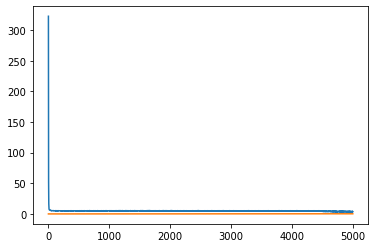

In [8]:
def main():
    #########################################################################
    # Here's some configuration:
    #########################################################################
    BATCH_SIZE = 256
    N_EPOCHS = 1

    train_ds, val_ds = prepare_data_loader(BATCH_SIZE)


    example_images, example_labels = next(iter(train_ds.take(1)))


    print("Initial Image size: ", example_images.shape)
    network = ResNet34()

    output = network(example_images)
    print("output shape:", output.shape)

    print(network.summary())




    epoch = tf.Variable(initial_value=tf.constant(0, dtype=tf.dtypes.int64), name='epoch')
    step_in_epoch = tf.Variable(
        initial_value=tf.constant(0, dtype=tf.dtypes.int64),
        name='step_in_epoch')


    # We need an optimizer.  Let's use Adam:
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

    checkpoint = tf.train.Checkpoint(
        network       = network,
        optimizer     = optimizer,
        epoch         = epoch,
        step_in_epoch = step_in_epoch)

    # Restore the model, if possible:
    latest_checkpoint = tf.train.latest_checkpoint("resnet34/")
    if latest_checkpoint:
        checkpoint.restore(latest_checkpoint)

    while epoch < N_EPOCHS:
        train_epoch(epoch, step_in_epoch, train_ds, val_ds, network, optimizer, BATCH_SIZE, checkpoint)
        epoch.assign_add(1)
        step_in_epoch.assign(0)

if __name__ == "__main__":
    main()